In [1]:
# Importing all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 4: Data pre-processing

In [2]:
# Loading the data
df = pd.read_csv('results.txt')
df.columns = ['id', 'num', 'image', 'label', 'time']
df.drop(["num"], axis=1, inplace=True)

# Removal of outliers
df.drop(df[df['time'] < 0.2].index, inplace=True)
df.drop(df[df['time'] > 3].index, inplace=True)

# Normalization of reaction times for each person
df['mean'] = df.groupby('id')['time'].transform('mean')
df['min'] = df.groupby('id')['time'].transform('min')
df['max'] = df.groupby('id')['time'].transform('max')
df['normalized'] = (df['time']-df['min']) / (2*(df['max'] - df['min']))

df['SmileNorm'] = 1-df['normalized']
df['score'] = df['normalized']
df['score'][df['label'] == "Smiling"] = df['SmileNorm']

df.head()

<ipython-input-2-89816bc61f0b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'][df['label'] == "Smiling"] = df['SmileNorm']


,id,image,label,time,mean,min,max,normalized,SmileNorm,score
0,7,55_1_0_20170103183939755.jpg.chip.jpg,Smiling,0.7776,0.826893,0.4476,2.2428,0.091912,0.908088,0.908088
1,7,42_1_0_20170105173320357.jpg.chip.jpg,Smiling,0.5956,0.826893,0.4476,2.2428,0.041221,0.958779,0.958779
2,7,26_1_1_20170112205848764.jpg.chip.jpg,Smiling,0.6308,0.826893,0.4476,2.2428,0.051025,0.948975,0.948975
3,7,28_0_3_20170113153014880.jpg.chip.jpg,Not smiling,0.6131,0.826893,0.4476,2.2428,0.046095,0.953905,0.046095
4,7,50_0_0_20170113184603160.jpg.chip.jpg,Not smiling,0.7651,0.826893,0.4476,2.2428,0.088430,0.911570,0.088430


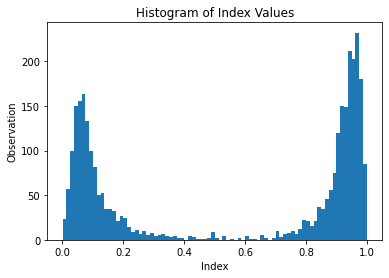

In [7]:
# Plotting histogram of index values
plt.title('Histogram of Index Values')
plt.hist(df['score'], bins = 80)
plt.xlabel('Index')
plt.ylabel('Observation')
plt.savefig('index histogram.png', dpi = 300, bbox_inches='tight')

# 5: PCA and feature selection

In [8]:
# Loading the images
images = [cv2.imread(file) for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
image_names = [str(file).split('\\')[1] for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
im = np.array(images)

print(f"There are {len(images)} images in our dataset, and the shape of our images are {images[0].shape}")

There are 398 images in our dataset, and the shape of our images are (200, 200, 3)


In [9]:
# Convert images to 1D arrays, and combine all images in one 2D array
big_im = np.zeros([120000,len(images)])
for i in range(len(images)):
    big_im[:,i] = images[i].reshape(120000)

# Get the means of each pixel and subtract mean from every image
means = np.mean(big_im, axis=1)
subtracted_mean = (big_im.T - means).T

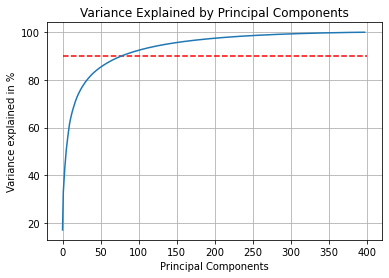

In [12]:
# run pca
pca = PCA()
S = pca.fit_transform(subtracted_mean)

# plot variance of PCA components
variance = pca.explained_variance_ratio_

plt.grid()
plt.plot(np.cumsum(variance)*100)
plt.hlines(90, 0, 400, colors='red', linestyles='dashed')
plt.title('Variance Explained by Principal Components')
plt.ylabel('Variance explained in %')
plt.xlabel('Principal Components')
plt.savefig('Variance explained.png', dpi = 300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

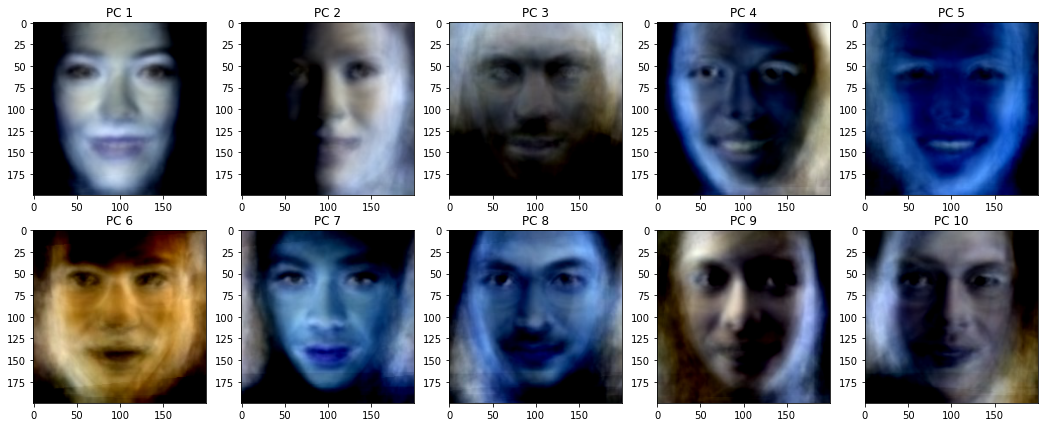

In [51]:
# Convert the components to 200x200x3 image shapes, and plot the first 10
pca_im = S[:,0].reshape([200,200,3])
pca_ims = S.reshape([200,200,3,len(images)])
pca_sub = ((means - S.T).T).reshape([200,200,3,len(images)])
    
fig = plt.figure(figsize=(18,7))
columns = 5
rows = 2
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img = pca_sub[:,:,:,i]
    # We find the max pixel value and divide by that so the image can be better visualized
    img = img/np.amax([np.amax(img[:,:,0]), np.amax(img[:,:,1]), np.amax(img[:,:,2])])
    plt.imshow(img)
    plt.title('PC '+str(i+1))
   
plt.show()
fig.savefig('Scaled PCs.png', dpi = 650, bbox_inches='tight')

# 6 & 7: Feature Selection and Linear Regression Model

Before we start with the feature selection and linear resression model, we first need to make a new dataframe. This dataframe will contain each image, all the scores for the images, and the average score for each image. We will then use this dataframe, as well as the loaded images from the previous section, to create our X and y data. Finally we split it up into train and test sets using an 80/20 ratio, and then apply PCA on them.

In [52]:
# Create a new dataframe with all the image names
df2 = pd.DataFrame(image_names)
df2.columns = (["image"])

# Add the scores for each person to the dataframe
count = 1
for i in df.groupby("id"):
    grouped_df = i[1][["image","score"]]
    grouped_df.columns = ['image', 'score'+str(count)]
    df2 = pd.merge(df2, grouped_df,how="left", on=["image"])
    count += 1
    
# Take the average score
df2['average'] = df2.mean(numeric_only=True, axis=1)
df2.head()

,image,score1,score2,score3,score4,score5,score6,score7,score8,average
0,20_0_0_20170104230048181.jpg.chip.jpg,0.035245,0.057297,0.078916,0.367870,0.052935,0.083465,0.035031,0.074326,0.098136
1,20_0_1_20170116010734667.jpg.chip.jpg,0.092742,0.839078,0.878550,0.111018,0.943465,NaN,0.884159,0.909813,0.665546
2,20_1_0_20170104021334149.jpg.chip.jpg,0.218306,0.035728,0.043450,0.085339,0.068924,0.082492,0.038197,0.083955,0.082049
3,20_1_0_20170113005610158.jpg.chip.jpg,0.789104,0.865095,0.953187,0.197193,0.908860,0.808310,0.927500,0.118308,0.695945
4,20_1_2_20170108224234471.jpg.chip.jpg,0.885110,0.994107,0.949461,0.919981,0.989179,0.941248,0.946870,0.939748,0.945713


In [53]:
# Train/test split
X = big_im.T
y = df2[['average']].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

#scale the training and testing data
pca = PCA()
X_train_pca = pca.fit_transform(scale(X_train))
X_test_pca = pca.transform(scale(X_test))
print('Training dataset shape:', X_train_pca.shape, y_train.shape)
print('Testing dataset shape:', X_test_pca.shape, y_test.shape)

Training dataset shape: (318, 318) (318, 1)
Testing dataset shape: (80, 318) (80, 1)


# 6: Feature Selection

In [54]:
# Cut down to the PCA components which explain 90% of the variance
# This is to make the forward selection slightly faster
threshold = 0.90

for i in range(len(variance)):
    
    if sum(variance[0:i+1]) >= threshold:
        num_features = i + 1
        break

# Extract subset of PC's
print(f"{num_features} features explain 90% of the variance of our dataset")
X_reduced_train = X_train_pca[:,:num_features]
X_reduced_test = X_test_pca[:,:num_features]
print('Reduced training dataset shape:', X_reduced_train.shape, y_train.shape)
print('Reduced testing dataset shape:', X_reduced_test.shape, y_test.shape)

79 features explain 90% of the variance of our dataset
Reduced training dataset shape: (318, 79) (318, 1)
Reduced testing dataset shape: (80, 79) (80, 1)


In [55]:
# Feature selection using sklearn's Sequential Feature Selector
results = []
for i in range(1,50):
    
    # Build RF classifier to use in feature selection
    regr = LinearRegression()
    
    # Build step forward feature selection
    sfs1 = sfs(regr, n_features_to_select=i, direction="forward", cv=5)

    # Perform SFFS
    sfs1 = sfs1.fit(X_reduced_train, y_train)
    regr.fit(X_reduced_train[:,sfs1.get_support()], y_train)

    #calculate RMSE
    pred = regr.predict(X_reduced_test[:,sfs1.get_support()])
    print(f"{i}: {np.sqrt(mean_squared_error(y_test, pred))}")
    results.append(np.sqrt(mean_squared_error(y_test, pred)))

1: 0.3585002628622956
2: 0.3390121368685084
3: 0.30827079348087494
4: 0.2973591465800799
5: 0.2902314406407667
6: 0.29581108748185986
7: 0.28821488475984025
8: 0.2902317484542894
9: 0.2910461255322193
10: 0.27911722755152873
11: 0.2742300391746941
12: 0.272679914453345
13: 0.27084883657948816
14: 0.26394149663540567
15: 0.2691651362294665
16: 0.2713648231816065
17: 0.2714652475280057
18: 0.271304685631667
19: 0.2671894759929596
20: 0.259670252276167
21: 0.25597996967328923
22: 0.24869506263223243
23: 0.241173792882487
24: 0.23745273211929085
25: 0.23882553253647487
26: 0.2362844680839165
27: 0.23812962857988762
28: 0.23896929027233607
29: 0.2375406490332118
30: 0.23543124844147026
31: 0.233132150881091
32: 0.23096977211381114
33: 0.23552581101288672
34: 0.23589884043793166
35: 0.23625177039184642
36: 0.23569925672683853
37: 0.23578131608302852
38: 0.2386635766357181
39: 0.23928875384343318
40: 0.2399166698829331
41: 0.240235651247049
42: 0.24111569209880543
43: 0.24300879083751661
44: 

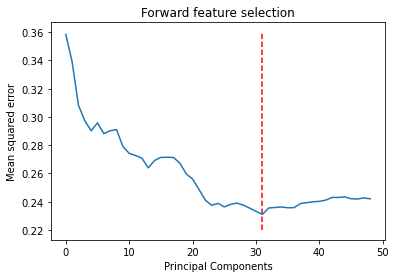

In [66]:
# Plotting the mean squared error of the models against the number of features in the model
plt.plot(results)
plt.title('Forward feature selection')
plt.xlabel('Principal Components')
plt.ylabel('Mean squared error')
plt.vlines(31, 0.22, 0.36, colors = 'r', linestyle = 'dashed')
plt.savefig('Forward selection.png', dpi = 300, bbox_inches='tight')

# 7: Linear Regression Model

From the plot above, we can see that using the mean squared error goes down until around 32 pca components are used, and from then on it stays about the same, even starting to increase again, so we will use 32 pca components for our linear regression model.

In [ ]:
# Build step forward feature selection
n = 32
sfs2 = sfs(regr, n_features_to_select=n, direction="forward", cv=5)

# Perform SFFS
sfs2 = sfs2.fit(X_reduced_train, y_train)
#print(sfs1.get_support())

regr.fit(X_reduced_train[:,sfs2.get_support()], y_train)
pred = regr.predict(X_reduced_test[:,sfs2.get_support()])
print(f"The mean squared error for our model with {n} features is {np.sqrt(mean_squared_error(y_test, pred))} \n")

# Show the model's prediction vs real value of the first 10 test pictures
for i in range(10):
    print(f"For picture {i}: predicted {pred[i]} and real answer is {y_test[i]}")

In [14]:

"""
# Linear model hvor vi bruger alle PCA fra første feature selection

#scale the training and testing data
pca = PCA(n_components = num_features)
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:num_features]
print('Training dataset shape:', X_reduced_train.shape, y_train.shape)
print('Testing dataset shape:', X_reduced_test.shape, y_test.shape)

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:num_features], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

"""

"\n# Linear model hvor vi bruger alle PCA fra første feature selection\n\n#scale the training and testing data\npca = PCA(n_components = num_features)\nX_reduced_train = pca.fit_transform(scale(X_train))\nX_reduced_test = pca.transform(scale(X_test))[:,:num_features]\nprint('Training dataset shape:', X_reduced_train.shape, y_train.shape)\nprint('Testing dataset shape:', X_reduced_test.shape, y_test.shape)\n\n#train PCR model on training data \nregr = LinearRegression()\nregr.fit(X_reduced_train[:,:num_features], y_train)\n\n#calculate RMSE\npred = regr.predict(X_reduced_test)\nnp.sqrt(mean_squared_error(y_test, pred))\n\n"

# 8: Generate samples

In [ ]:
S2 = pca.fit_transform(X_train.T)[:,:num_features]
S2.shape

In [ ]:
xs = []
for i in np.arange(-0.25,1.5,0.25):
    alpha = (i - np.sum(regr.intercept_)) / np.sum(abs(regr.coef_))
    x = alpha*regr.coef_
    xs.append(x)

In [ ]:
fig = plt.figure(figsize=(20,10))
columns = 7
rows = 1
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img = (xs[i] @ S2[:,sfs2.get_support()].T).reshape([200,200,3])
    img = img/np.amax([np.amax(img[:,:,0]), np.amax(img[:,:,1]), np.amax(img[:,:,2])]) 
    plt.imshow(img)
plt.show()

# 9 Constructing continuum without reaction times

Text(0.5, 1.0, 'Mean not smile')

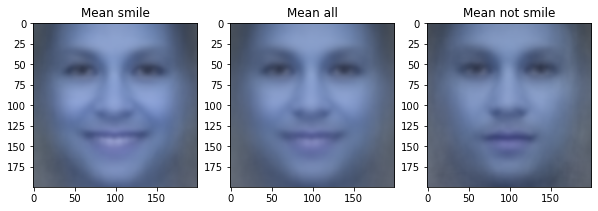

In [18]:
#Generating continuum of faces based on only the pixel-values
score_matrix = np.hstack((X,y))

# Dividing into the two classes based on score
score_matrix_smile = score_matrix[score_matrix[:,-1] > 0.5]
score_matrix_not_smile = score_matrix[score_matrix[:,-1] <= 0.5]

# Removing the last columns containing the scores 
score_matrix_smile_new = np.delete(score_matrix_smile,-1,1)
score_matrix_not_smile_new = np.delete(score_matrix_not_smile,-1,1)
score_matrix_new = np.delete(score_matrix,-1,1)

# Finding the mean images from smile class
mean_smile = np.mean(score_matrix_smile_new,0)
mean_smile_img = mean_smile.reshape([200,200,3])
fig = plt.figure(figsize=(10,7))
plt.subplot(1,3,1)
plt.imshow(mean_smile_img/255)
plt.title('Mean smile')

# Finding overall mean
mean_all = np.mean(score_matrix_new,0)
mean_all_img = mean_all.reshape([200,200,3])
plt.subplot(1,3,2)
plt.imshow(mean_all_img/255)
plt.title('Mean all')

# Finding mean from not smile class
mean_not_smile = np.mean(score_matrix_not_smile_new,0)
mean_not_smile_img = mean_not_smile.reshape([200,200,3])
plt.subplot(1,3,3)
plt.imshow(mean_not_smile_img/255)
plt.title('Mean not smile')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Difference')

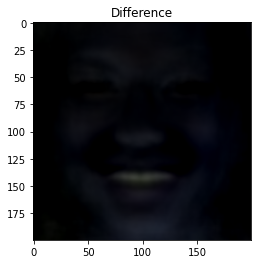

In [19]:
difference = mean_smile - mean_not_smile
difference_img = difference.reshape([200,200,3])
fig = plt.figure(figsize=(5,4))
plt.imshow(difference_img/255)
plt.title('Difference')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Super not smile')

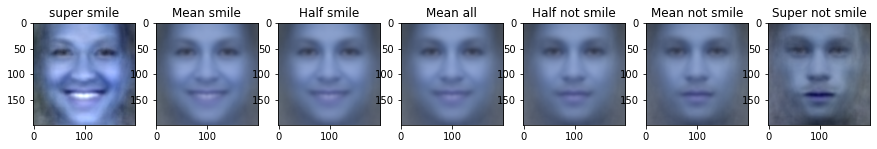

In [20]:
super_smile = mean_smile + 2*difference
super_smile_img = super_smile.reshape([200,200,3])
fig = plt.figure(figsize=(15,10))
plt.subplot(1,7,1)
plt.imshow(super_smile_img/255)
plt.title('super smile')

plt.subplot(1,7,2)
plt.imshow(mean_smile_img/255)
plt.title('Mean smile')

half_smile = mean_smile - difference/4
half_smile_img = half_smile.reshape([200,200,3])
plt.subplot(1,7,3)
plt.imshow(half_smile_img/255)
plt.title('Half smile')

plt.subplot(1,7,4)
plt.imshow(mean_all_img/255)
plt.title('Mean all')

half_not_smile = mean_not_smile + difference/4
half_not_smile_img = half_not_smile.reshape([200,200,3])
plt.subplot(1,7,5)
plt.imshow(half_not_smile_img/255)
plt.title('Half not smile')

plt.subplot(1,7,6)
plt.imshow(mean_not_smile_img/255)
plt.title('Mean not smile')

super_not_smile = mean_not_smile - difference
super_not_smile_img = super_not_smile.reshape([200,200,3])
plt.subplot(1,7,7)
plt.imshow(super_not_smile_img/255)
plt.title('Super not smile')

In [21]:
print(f"From section 6 we know that {num_features} PCA components are required to explain 90% of the variance")

# Create PCA which explains 90% variance
pca_90 = PCA(num_features)
X_pca = pca_90.fit_transform(X)

# Recreate the images using the PCA components
X_proj = pca_90.inverse_transform(X_pca)

From section 6 we know that 79 PCA components are required to explain 90% of the variance


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Super not smile')

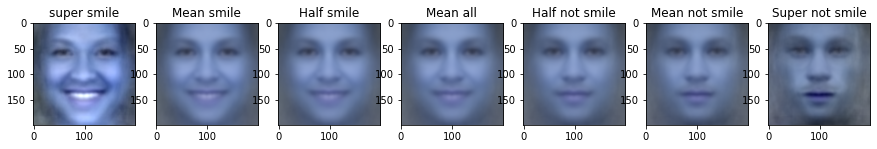

In [22]:
#Generating continuum of faces based on only the pixel-values
proj_score_matrix = np.hstack((X_proj,y))

# Dividing into the two classes based on score
proj_score_matrix_smile = proj_score_matrix[proj_score_matrix[:,-1] > 0.5]
proj_score_matrix_not_smile = proj_score_matrix[proj_score_matrix[:,-1] <= 0.5]

# Removing the last columns containing the scores 
proj_score_matrix_smile_new = np.delete(proj_score_matrix_smile,-1,1)
proj_score_matrix_not_smile_new = np.delete(proj_score_matrix_not_smile,-1,1)
proj_score_matrix_new = np.delete(proj_score_matrix,-1,1)

# Finding the mean images from smile class
proj_mean_smile = np.mean(proj_score_matrix_smile_new,0)
proj_mean_smile_img = proj_mean_smile.reshape([200,200,3])

# Finding overall mean
proj_mean_all = np.mean(proj_score_matrix_new,0)
proj_mean_all_img = proj_mean_all.reshape([200,200,3])

# Finding mean from not smile class
proj_mean_not_smile = np.mean(proj_score_matrix_not_smile_new,0)
proj_mean_not_smile_img = proj_mean_not_smile.reshape([200,200,3])

# Finding the difference
proj_difference = proj_mean_smile - proj_mean_not_smile

# Plotting images
proj_super_smile = proj_mean_smile + 2*proj_difference
proj_super_smile_img = proj_super_smile.reshape([200,200,3])
fig = plt.figure(figsize=(15,10))
plt.subplot(1,7,1)
plt.imshow(proj_super_smile_img/255)
plt.title('super smile')

plt.subplot(1,7,2)
plt.imshow(proj_mean_smile_img/255)
plt.title('Mean smile')

proj_half_smile = proj_mean_smile - proj_difference/4
proj_half_smile_img = proj_half_smile.reshape([200,200,3])
plt.subplot(1,7,3)
plt.imshow(proj_half_smile_img/255)
plt.title('Half smile')

plt.subplot(1,7,4)
plt.imshow(proj_mean_all_img/255)
plt.title('Mean all')

proj_half_not_smile = proj_mean_not_smile + proj_difference/4
proj_half_not_smile_img = proj_half_not_smile.reshape([200,200,3])
plt.subplot(1,7,5)
plt.imshow(proj_half_not_smile_img/255)
plt.title('Half not smile')

plt.subplot(1,7,6)
plt.imshow(proj_mean_not_smile_img/255)
plt.title('Mean not smile')

proj_super_not_smile = proj_mean_not_smile - proj_difference
proj_super_not_smile_img = proj_super_not_smile.reshape([200,200,3])
plt.subplot(1,7,7)
plt.imshow(proj_super_not_smile_img/255)
plt.title('Super not smile')

# 10